# Getting started with Gammapy

## Introduction

This is a getting started tutorial for [Gammapy](http://docs.gammapy.org/).

In this tutorial we will use the [Second Fermi-LAT Catalog of High-Energy Sources (2FHL) catalog](http://fermi.gsfc.nasa.gov/ssc/data/access/lat/2FHL/), corresponding event list and images to learn how to work with some of the central Gammapy data structures.

We will cover the following topics:

* **Sky maps**
  * We will learn how to handle image based data with gammapy using a Fermi-LAT 2FHL example image. We will work with the following classes:
    - [gammapy.maps.WcsNDMap](http://docs.gammapy.org/dev/api/gammapy.maps.WcsNDMap.html)
    - [astropy.coordinates.SkyCoord](http://astropy.readthedocs.io/en/latest/coordinates/index.html)
    - [numpy.ndarray](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html)

* **Event lists**
  * We will learn how to handle event lists with Gammapy. Important for this are the following classes: 
    - [gammapy.data.EventList](http://docs.gammapy.org/dev/api/gammapy.data.EventList.html)
    - [astropy.table.Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table)

* **Source catalogs**
  * We will show how to load source catalogs with Gammapy and explore the data using the following classes:
    - [gammapy.catalog.SourceCatalog](http://docs.gammapy.org/dev/api/gammapy.catalog.SourceCatalog.html), specifically [gammapy.catalog.SourceCatalog2FHL](http://docs.gammapy.org/dev/api/gammapy.catalog.SourceCatalog2FHL.html)
    - [astropy.table.Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table)

* **Spectral models and flux points**
  * We will pick an example source and show how to plot its spectral model and flux points. For this we will use the following classes:
    - [gammapy.spectrum.SpectralModel](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.SpectralModel.html), specifically the [PowerLaw2](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.PowerLaw2.html) model.
    - [gammapy.spectrum.FluxPoints](http://docs.gammapy.org/dev/api/gammapy.spectrum.FluxPoints.html#gammapy.spectrum.FluxPoints)
    - [astropy.table.Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table)

If you're not yet familiar with the listed Astropy classes, maybe check out the [Astropy introduction for Gammapy users](astropy_introduction.ipynb) first.

## Setup

**Important**: to run this tutorial the environment variable `GAMMAPY_EXTRA` must be defined and point to the directory, where the gammapy-extra is respository located on your machine. To check whether your setup is correct you can execute the following cell:



In [ ]:
import os

path = os.path.expandvars('$GAMMAPY_EXTRA/datasets')

if not os.path.exists(path):
    raise Exception('gammapy-extra repository not found!')
else:
    print('Great your setup is correct!')

In case you encounter an error, you can un-comment and execute the following cell to continue. But we recommend to set up your enviroment correctly as decribed [here](http://docs.gammapy.org/dev/datasets/index.html#gammapy-extra) after you are done with this notebook.

In [2]:
#os.environ['GAMMAPY_EXTRA'] = os.path.join(os.getcwd(), '..')

Now we can continue with the usual IPython notebooks and Python imports:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm

## Maps

The [gammapy.maps](http://docs.gammapy.org/dev/maps) package contains classes to work with sky images and cubes.

In this section, we will use a simple 2D sky image and will learn how to:

* Read sky images from FITS files
* Smooth images
* Plot images
* Cutout parts from images
* Reproject images to different WCS

In [5]:
from gammapy.maps import Map
vela_2fhl = Map.read("$GAMMAPY_EXTRA/datasets/fermi_2fhl/fermi_2fhl_vela.fits.gz", hdu='COUNTS')

As the FITS file `fermi_2fhl_vela.fits.gz` contains mutiple image extensions and a map can only represent a single image, we explicitely specify to read the extension called 'COUNTS'.

The image is a ``WCSNDMap`` object:

In [6]:
vela_2fhl

WcsNDMap

	geom      : Wcs 
 	unit      :  
	data shape: (180, 320)
	data mean : 2.7e-02 
	data min  : 0.0e+00 
	data max  : 4.0e+00 

The shape of the image is 320x180 pixel and it is defined using a cartesian projection in galactic coordinates.

The ``geom`` attribute is a ``WcsGeom`` object:

In [7]:
vela_2fhl.geom

WcsGeom

	npix      : 320 x 180 pix
	coordsys  : GAL
	projection: CAR
	center    : 266.0 deg, -1.2 deg
	width     : 32.0 x 18.0 deg
	ndim      : 2
	axes      : 

Let's take a closer look a the `.data` attribute:

In [8]:
vela_2fhl.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

That looks familiar! It just an *ordinary* 2 dimensional numpy array,  which means you can apply any known numpy method to it:

In [9]:
print('Total number of counts in the image: {:.0f}'.format(vela_2fhl.data.sum()))

Total number of counts in the image: 1567


To show the image on the screen we can use the ``plot`` method. It basically calls [plt.imshow](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow), passing the `vela_2fhl.data` attribute but in addition handles axis with world coordinates using [wcsaxes](https://wcsaxes.readthedocs.io/en/latest/) and defines some defaults for nicer plots (e.g. the colormap 'afmhot'):

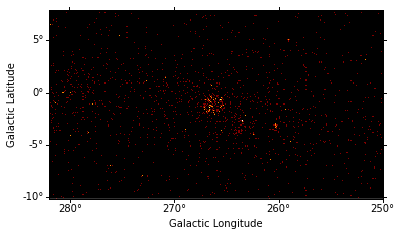

In [10]:
vela_2fhl.plot();

To make the structures in the image more visible we will smooth the data using a Gausian kernel with a radius of 0.5 deg. Again `smooth()` is a wrapper around existing functionality from the scientific Python libraries. In this case it is Scipy's [gaussian_filter](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.ndimage.filters.gaussian_filter.html) method. For convenience the kernel shape can be specified with as string and the smoothing radius with a quantity. It returns again a map object, that we can plot directly the same way we did above:

In [11]:
vela_2fhl_smoothed = vela_2fhl.smooth(kernel='gauss', radius=0.5 * u.deg)

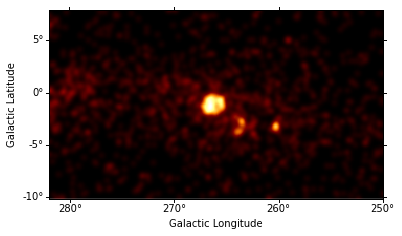

In [12]:
vela_2fhl_smoothed.plot();

The smoothed plot already looks much nicer, but still the image is rather large. As we are mostly interested in the inner part of the image, we will cut out a quadratic region of the size 9 deg x 9 deg around Vela. Therefore we use ``make_cutout`` to make a cutout map:

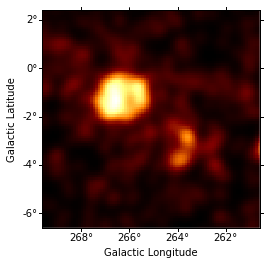

In [13]:
# define center and size of the cutout region
center = SkyCoord(265.0, -2.0, unit='deg', frame='galactic')
vela_2fhl_cutout, _ = vela_2fhl_smoothed.make_cutout(center, 9 * u.deg)
vela_2fhl_cutout.plot();

To make this exercise a bit more scientifically useful, we will load a second image containing WMAP data from the same region:

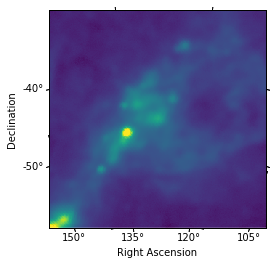

In [14]:
vela_wmap = Map.read("$GAMMAPY_EXTRA/datasets/images/Vela_region_WMAP_K.fits")

# define a norm to stretch the data, so it is better visible
norm = simple_norm(vela_wmap.data, stretch='sqrt', max_percent=99.9)
vela_wmap.plot(cmap='viridis', norm=norm);

In order to make the structures in the data better visible we used the [simple_norm()](http://docs.astropy.org/en/stable/api/astropy.visualization.mpl_normalize.simple_norm.html#astropy.visualization.mpl_normalize.simple_norm) method, which allows to stretch the data for plotting. This is very similar to the methods that e.g. `ds9` provides. In addition we used a different colormap called 'viridis'. An overview of different colomaps can be found [here](http://matplotlib.org/examples/color/colormaps_reference.html). 

Now let's check the details of the WMAP image:

In [15]:
vela_wmap

WcsNDMap

	geom      : Wcs 
 	unit      :  
	data shape: (300, 300)
	data mean : 1.8e+00 
	data min  : 1.4e-01 
	data max  : 6.7e+01 

As you can see it is defined using a tangential projection and ICRS coordinates, which is different from the projection used for the `vela_2fhl` image. To compare both images we have to reproject one image to the WCS of the other. This can be achieved with the ``reproject`` method: 

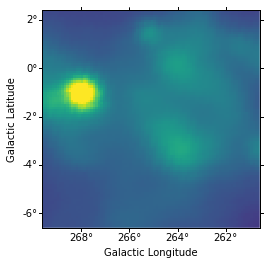

In [16]:
# reproject and cut out the part we're interested in:
vela_wmap_reprojected = vela_wmap.reproject(vela_2fhl.geom)
vela_wmap_reprojected_cutout, _ = vela_wmap_reprojected.make_cutout(center, 9 * u.deg)
vela_wmap_reprojected_cutout.plot(cmap='viridis', norm=norm);

Finally we will combine both images in single plot, by plotting WMAP contours on top of the smoothed Fermi-LAT 2FHL image:


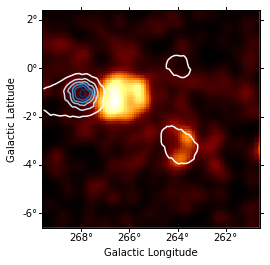

In [17]:
fig, ax, _ = vela_2fhl_cutout.plot()
ax.contour(vela_wmap_reprojected_cutout.data, cmap='Blues')

### Exercises

* Add a marker and circle at the Vela pulsar position (you can find examples in the WCSAxes [documentation](https://wcsaxes.readthedocs.io/en/latest/overlays.html)).

## Event lists

Almost any high-level gamma-ray data analysis starts with the raw measured counts data, which is stored in event lists. In Gammapy event lists are represented by the [gammapy.data.EventList](http://docs.gammapy.org/dev/api/gammapy.data.EventList.html) class. 

In this section we will learn how to:

* Read event lists from FITS files
* Access and work with the `EventList` attributes such as `.table` and `.energy` 
* Filter events lists using convenience methods

Let's start with the import from the [gammapy.data](http://docs.gammapy.org/dev/data/index.html) submodule:

In [18]:
from gammapy.data import EventList

Very similar to the sky map class an event list can be created, by passing a filename to the `.read()` method:

In [19]:
events_2fhl = EventList.read('$GAMMAPY_EXTRA/datasets/fermi_2fhl/2fhl_events.fits.gz')

This time the actual data is stored as an [astropy.table.Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table) object. It can be accessed with `.table` attribute: 

In [20]:
events_2fhl.table

ENERGY,RA,DEC,L,B,THETA,PHI,ZENITH_ANGLE,EARTH_AZIMUTH_ANGLE,TIME,EVENT_ID,RUN_ID,RECON_VERSION,CALIB_VERSION [3],EVENT_CLASS [32],EVENT_TYPE [32],CONVERSION_TYPE,LIVETIME,DIFRSP0,DIFRSP1,DIFRSP2,DIFRSP3,DIFRSP4
MeV,deg,deg,deg,deg,deg,deg,deg,deg,s,,,,,,,,s,,,,,
float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int32,int32,int16,int16,bool,bool,int16,float64,float32,float32,float32,float32,float32
145927.23,291.6619,42.234055,74.54367,11.86778,38.045475,83.53583,55.638725,314.03378,239561457.86561257,4851437,239559565,0,0 .. 0,False .. True,False .. True,0,275.6980889737606,2.6965721e-11,3238.2458,0.0,0.0,0.0
221273.36,46.985752,-40.638943,247.48888,-58.873917,34.10511,224.20937,68.2524,198.31926,239562739.08500722,7521432,239559565,0,0 .. 0,False .. True,False .. True,0,64.79749315977097,1.5357299e-12,2774.1985,0.0,0.0,0.0
57709.242,121.84143,49.22879,169.86801,32.301655,71.56363,34.292484,36.717308,25.543858,239563180.30194944,8690693,239559565,0,0 .. 0,False .. True,False .. True,0,30.57218647003174,8.110957e-12,253.2212,0.0,0.0,0.0
221223.75,83.56263,-4.217438,207.7828,-19.077145,20.50894,92.16046,32.303345,239.14058,239563382.21257913,9208424,239559565,0,0 .. 0,False .. True,False .. True,0,27.412509590387344,1.6607507e-11,2980.1243,0.0,0.0,0.0
698996.9,320.89468,-1.327888,51.221825,-33.97183,35.36213,158.74147,12.086709,72.20295,239566572.9507265,2480483,239565645,0,0 .. 0,False .. True,False .. True,0,106.47548112273216,2.2654334e-13,2706.1436,0.0,0.0,0.0
119158.54,318.81128,12.30284,62.63608,-24.41602,26.589584,213.89417,17.7156,23.940882,239572348.06027594,1725276,239571670,0,0 .. 0,False .. True,False .. True,0,185.3464272916317,2.7567707e-11,3439.2861,0.0,0.0,0.0
56175.598,279.25122,47.883488,76.6915,22.07387,29.103403,61.004787,62.173084,321.10422,239572763.4307742,76017,239572736,0,0 .. 0,False .. True,False .. True,0,24.450733959674835,2.0826456e-10,4071.2454,0.0,0.0,0.0
1418123.2,100.31091,-47.44805,256.468,-21.264088,61.225597,294.17953,90.475266,144.14915,239573788.81279647,1781569,239572736,0,0 .. 0,False .. True,False .. True,0,68.27161464095116,3.200215e-14,1086.2307,0.0,0.0,0.0


Let's try to find the total number of events contained int the list. This doesn't work:


In [21]:
print('Total number of events: {}'.format(len(events_2fhl.table)))

Total number of events: 60978


Because Gammapy objects don't redefine properties, that are accessible from the underlying Astropy of Numpy data object.

So in this case of course we can directly use the `.table` attribute to find the total number of events:

In [22]:
print('Total number of events: {}'.format(len(events_2fhl.table)))

Total number of events: 60978


And we can access any other attribute of the `Table` object as well:

In [23]:
events_2fhl.table.colnames

['ENERGY',
 'RA',
 'DEC',
 'L',
 'B',
 'THETA',
 'PHI',
 'ZENITH_ANGLE',
 'EARTH_AZIMUTH_ANGLE',
 'TIME',
 'EVENT_ID',
 'RUN_ID',
 'RECON_VERSION',
 'CALIB_VERSION',
 'EVENT_CLASS',
 'EVENT_TYPE',
 'CONVERSION_TYPE',
 'LIVETIME',
 'DIFRSP0',
 'DIFRSP1',
 'DIFRSP2',
 'DIFRSP3',
 'DIFRSP4']

For convenience we can access the most important event parameters as properties on the `EventList` objects. The attributes will return corresponding Astropy objects to represent the data, such as [astropy.units.Quantity](http://docs.astropy.org/en/stable/api/astropy.units.Quantity.html#astropy.units.Quantity), [astropy.coordinates.SkyCoord](http://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) or [astropy.time.Time](http://docs.astropy.org/en/stable/api/astropy.time.Time.html#astropy.time.Time) objects:

In [24]:
events_2fhl.energy.to('GeV')

<Quantity [145.92725 , 221.27338 ,  57.709244, ...,  61.592117,  80.48079 ,
           124.449165] GeV>

In [25]:
events_2fhl.galactic
#events_2fhl.radec

<SkyCoord (Galactic): (l, b) in deg
    [( 74.54326949,  11.86794629), (247.48874019, -58.87409431),
     (169.86765712,  32.30144389), ..., (357.43496217,  40.64753602),
     (327.56037412,  10.95297324), (329.42901812,   2.30075607)]>

In [26]:
events_2fhl.time

<Time object: scale='tt' format='mjd' value=[54682.7028015  54682.71763043 54682.72273711 ... 57053.90824179
 57053.90933163 57053.91005343]>

In addition `EventList` provides convenience methods to filter the event lists. One possible use case is to find the highest energy event within a radius of 0.5 deg around the vela position:

In [27]:
# select all events within a radius of 0.5 deg around center
events_vela_2fhl = events_2fhl.select_sky_cone(center=center, radius=0.5 * u.deg)

# sort events by energy
events_vela_2fhl.table.sort('ENERGY')

# and show highest energy photon
events_vela_2fhl.energy[-1].to('GeV')

<Quantity 342.76625 GeV>

### Exercises

* Make a counts energy spectrum for the galactic center region, within a radius of 10 deg.

## Source catalogs

Gammapy provides a convenient interface to access and work with catalog based data. 

In this section we will learn how to:

* Load builtins catalogs from [gammapy.catalog](http://docs.gammapy.org/dev/catalog/index.html)
* Sort and index the underlying Astropy tables
* Access data from individual sources

Let's start with importing the 2FHL catalog object from the [gammapy.catalog](http://docs.gammapy.org/dev/catalog/index.html) submodule:

In [28]:
from gammapy.catalog import SourceCatalog2FHL

First we initialize the Fermi-LAT 2FHL catalog and directly take a look at the `.table` attribute:

In [29]:
fermi_2fhl = SourceCatalog2FHL('$GAMMAPY_EXTRA/datasets/catalogs/fermi/gll_psch_v08.fit.gz')
fermi_2fhl.table

Source_Name,RAJ2000,DEJ2000,GLON,GLAT,Pos_err_68,TS,Spectral_Index,Unc_Spectral_Index,Intr_Spectral_Index_D11,Unc_Intr_Spectral_Index_D11,Intr_Spectral_Index_G12,Unc_Intr_Spectral_Index_G12,Flux50,Unc_Flux50,Energy_Flux50,Unc_Energy_Flux50,Flux50_171GeV,Unc_Flux50_171GeV [2],Sqrt_TS50_171GeV,Flux171_585GeV,Unc_Flux171_585GeV [2],Sqrt_TS171_585GeV,Flux585_2000GeV,Unc_Flux585_2000GeV [2],Sqrt_TS585_2000GeV,Npred,HEP_Energy,HEP_Prob,ROI,ASSOC,ASSOC_PROB_BAY,ASSOC_PROB_LR,CLASS,Redshift,NuPeak_obs,3FGL_Name,1FHL_Name,TeVCat_Name
,deg,deg,deg,deg,deg,,,,,,,,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),erg / (cm2 s),1 / (cm2 s),1 / (cm2 s),,1 / (cm2 s),1 / (cm2 s),,1 / (cm2 s),1 / (cm2 s),,,GeV,,,,,,,,Hz,,,
bytes18,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bytes25,float32,float32,bytes8,float32,float32,bytes18,bytes18,bytes18
2FHL J0008.1+4709,2.0437,47.1642,115.339355,-15.068757,0.06111402,28.64,6.24,2.75,3.96,3.19,2.16,4.21,1.23e-11,6.71e-12,1.21e-12,6.71e-13,3.3634447e-12,-1.5366806e-12 .. 2.1609453e-12,5.353536,4.3494674e-18,nan .. 4.7538935e-12,0.0,8.448714e-18,nan .. 7.291014e-12,0.0,4.0,68.15,0.99,1,MG4 J000800+4712,0.99721974,0.8348271,bll,2.1,2511884200000000.0,3FGL J0008.0+4713,1FHL J0007.7+4709,
2FHL J0009.3+5031,2.3435,50.5217,116.12411,-11.793202,0.045439195,53.97,5.08,1.66,nan,nan,nan,nan,1.91e-11,7.82e-12,2.03e-12,8.79e-13,8.362822e-12,-2.9896227e-12 .. 3.895122e-12,7.351317,2.9145808e-17,nan .. 5.1000337e-12,0.0,3.5087458e-16,nan .. 4.874578e-12,0.0,6.4,72.76,1.0,1,NVSS J000922+503028,0.99972373,0.7348077,bll,0.0,1412536400000000.0,3FGL J0009.3+5030,1FHL J0009.2+5032,
2FHL J0018.5+2947,4.6355,29.7879,114.46349,-32.54235,0.037093636,30.89,2.58,0.99,2.41,1.04,2.4,1.04,1.06e-11,6.15e-12,2.05e-12,1.72e-12,9.65438e-12,-5.5534162e-12 .. 5.5534162e-12,5.765786,1.1790023e-15,nan .. 5.378652e-12,0.0,1.6046534e-16,nan .. 6.120081e-12,0.0,3.0,127.32,1.0,3,RBS 0042,0.9998682,0.97852194,bll,0.1,5.9156075e+16,3FGL J0018.4+2947,1FHL J0018.6+2946,
2FHL J0022.0+0006,5.5001,0.1059,107.171715,-61.86175,0.05118522,29.96,1.86,0.57,0.95,0.72,0.88,0.71,1.97e-11,9.56e-12,6.86e-12,5.29e-12,1.6119727e-11,-7.1725507e-12 .. 9.9534886e-12,5.3821964,3.6392152e-12,-4.3863624e-12 .. 4.3863624e-12,1.3853942,8.423558e-16,nan .. 7.342399e-12,0.0,4.8,180.13,0.86,2,5BZGJ0022+0006,0.99928,0.90008944,bll-g,0.306,4.315193e+16,,,
2FHL J0033.6-1921,8.4115,-19.3575,94.28002,-81.22237,0.034838412,148.31,3.32,0.69,2.56,0.88,2.33,0.92,5.46e-11,1.5e-11,7.62e-12,2.69e-12,4.0016098e-11,-1.0161534e-11 .. 1.223782e-11,12.172502,2.1390131e-12,nan .. 8.258118e-12,0.9079581,2.439548e-17,nan .. 6.8422585e-12,0.0,13.8,170.01,0.99,2,KUV 00311-1938,0.999759,0.9814242,bll,0.61,8317639000000000.0,3FGL J0033.6-1921,1FHL J0033.6-1921,TeV J0033-1921
2FHL J0035.8+5949,8.9625,59.8312,120.97197,-2.9812155,0.031602595,402.4,2.23,0.21,nan,nan,nan,nan,1.25e-10,1.9e-11,3.11e-11,7.23e-12,9.4229395e-11,-1.5256577e-11 .. 1.7157154e-11,17.312449,2.6699127e-11,-7.628179e-12 .. 9.450845e-12,10.390878,3.7260905e-16,nan .. 4.6744392e-12,0.0,46.5,247.62,0.96,4,1ES 0033+595,0.99995834,0.9928678,bll,0.0,1.3182593e+17,3FGL J0035.9+5949,1FHL J0035.9+5950,TeV J0035+5950
2FHL J0040.3+4049,10.0949,40.8315,120.676285,-21.991812,0.035514843,26.76,2.12,0.81,nan,nan,nan,nan,1.05e-11,6.3e-12,2.84e-12,2.67e-12,7.415768e-12,-4.077804e-12 .. 6.4518156e-12,4.954423,3.0030787e-12,-2.317754e-12 .. 4.466438e-12,1.7083547,4.7316626e-16,nan .. 5.7980946e-12,0.0,3.2,258.77,0.85,3,B3 0037+405,0.9987379,0.9346999,bcu I,0.0,1.0,3FGL J0040.3+4049,1FHL J0040.3+4049,
2FHL J0043.9+3424,10.9755,34.4109,121.16442,-28.434984,0.059241667,39.5,4.57,1.61,3.46,1.85,2.95,1.91,1.83e-11,8.24e-12,2.03e-12,9.93e-13,9.657617e-12,-4.316866e-12 .. 4.316866e-12,6.3115244,8.758609e-17,nan .. 5.2433453e-12,0.0,9.438122e-16,nan .. 5.687869e-12,0.0,5.4,109.97,0.9,3

This looks very familiar again. The data is just stored as an [astropy.table.Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table) object. We have all the methods and attributes of the `Table` object available. E.g. we can sort the underlying table by `TS` to find the top 5 most significant sources:



In [30]:
# sort table by TS
fermi_2fhl.table.sort('TS')

# invert the order to find the highest values and take the top 5 
top_five_TS_2fhl = fermi_2fhl.table[::-1][:5]

# print the top five significant sources with association and source class
top_five_TS_2fhl[['Source_Name', 'ASSOC', 'CLASS']]

Source_Name,ASSOC,CLASS
bytes18,bytes25,bytes8
2FHL J1104.4+3812,Mkn 421,bll
2FHL J0534.5+2201,Crab,pwn
2FHL J1653.9+3945,Mkn 501,bll
2FHL J1555.7+1111,PG 1553+113,bll
2FHL J2158.8-3013,PKS 2155-304,bll


If you are interested in the data of an individual source you can access the information from catalog using the name of the source or any alias source name that is defined in the catalog:

In [31]:
mkn_421_2fhl = fermi_2fhl['2FHL J1104.4+3812']

# or use any alias source name that is defined in the catalog
mkn_421_2fhl = fermi_2fhl['Mkn 421']
print(mkn_421_2fhl.data['TS'])

5600.98


### Exercises

* Try to load the Fermi-LAT 3FHL catalog and check the total number of sources it contains.
* Select all the sources from the 2FHL catalog which are contained in the Vela region. Add markers for all these sources and try to add labels with the source names. The function [ax.text()](http://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.text.html#matplotlib.axes.Axes.text) might be helpful.
* Try to find the source class of the object at position ra=68.6803, dec=9.3331
 

## Spectral models and flux points

In the previous section we learned how access basic data from individual sources in the catalog. Now we will go one step further and explore the full spectral information of sources. We will learn how to:

* Plot spectral models
* Compute integral and energy fluxes
* Read and plot flux points

As a first example we will start with the Crab Nebula:

In [32]:
crab_2fhl = fermi_2fhl['Crab']
print(crab_2fhl.spectral_model)

PowerLaw2

Parameters: 

	   name     value     error       unit    min max frozen
	--------- --------- --------- ----------- --- --- ------
	amplitude 1.310e-09 6.830e-11 1 / (cm2 s) nan nan  False
	    index 2.130e+00 7.000e-02             nan nan  False
	     emin 5.000e-02 0.000e+00         TeV nan nan   True
	     emax 2.000e+00 0.000e+00         TeV nan nan   True

Covariance: 

	name/name amplitude index 
	--------- --------- ------
	amplitude  4.66e-21    0.0
	    index       0.0 0.0049


The `crab_2fhl.spectral_model` is an instance of the [gammapy.spectrum.models.PowerLaw2](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.PowerLaw2.html#gammapy.spectrum.models.PowerLaw2) model, with the parameter values and errors taken from the 2FHL catalog. 

Let's plot the spectral model in the energy range between 50 GeV and 2000 GeV:

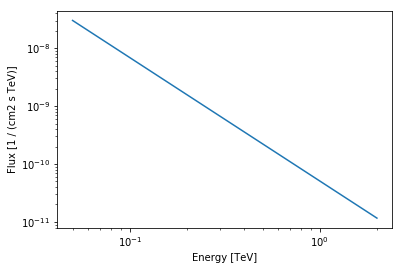

In [33]:
ax_crab_2fhl = crab_2fhl.spectral_model.plot(
    energy_range=[50, 2000] * u.GeV, energy_power=0)

We assign the return axes object to variable called `ax_crab_2fhl`, because we will re-use it later to plot the flux points on top.

To compute the differential flux at 100 GeV we can simply call the model like normal Python function and convert to the desired units:

In [34]:
crab_2fhl.spectral_model(100 * u.GeV).to('cm-2 s-1 GeV-1')

<Quantity 6.87004773e-12 1 / (cm2 GeV s)>

Next we can compute the integral flux of the Crab between 50 GeV and 2000 GeV:

In [35]:
crab_2fhl.spectral_model.integral(
    emin=50 * u.GeV, emax=2000 * u.GeV,
).to('cm-2 s-1')

<Quantity 1.31e-09 1 / (cm2 s)>

We can easily convince ourself, that it corresponds to the value given in the Fermi-LAT 2FHL catalog:

In [36]:
crab_2fhl.data['Flux50']

<Quantity 1.31e-09 1 / (cm2 s)>

In addition we can compute the energy flux between 50 GeV and 2000 GeV:

In [37]:
crab_2fhl.spectral_model.energy_flux(
    emin=50 * u.GeV, emax=2000 * u.GeV,
).to('erg cm-2 s-1')

<Quantity 3.52953994e-10 erg / (cm2 s)>

Next we will access the flux points data of the Crab:

In [38]:
print(crab_2fhl.flux_points)

FluxPoints(sed_type="dnde", n_points=3)


If you want to learn more about the different flux point formats you can read the specification [here](http://gamma-astro-data-formats.readthedocs.io/en/latest/results/flux_points/index.html#flux-points).

No we can check again the underlying astropy data structure by accessing the `.table` attribute:

In [39]:
crab_2fhl.flux_points.table

e_min,e_max,flux,flux_errn,flux_errp,is_ul,flux_ul,e_ref,dnde,dnde_errn,dnde_errp,dnde_ul
GeV,GeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,1 / (cm2 s),GeV,1 / (cm2 GeV s),1 / (cm2 GeV s),1 / (cm2 GeV s),1 / (cm2 GeV s)
float64,float64,float64,float32,float32,bool,float64,float64,float64,float64,float64,float64
50.0,171.0,9.94072046900385e-10,5.7595e-11,5.947264e-11,False,nan,92.46621004453465,8.077278257256764e-12,4.679850482507369e-13,4.832417130565079e-13,nan
171.0,585.0,2.4387539210302123e-10,2.8254246e-11,3.0435404e-11,False,nan,316.2831010345004,5.791573933479777e-13,6.70984284998247e-14,7.227826148494206e-14,nan
585.0,2000.0,5.275358622158777e-11,1.3340122e-11,1.6047759e-11,False,nan,1081.6653826391969,3.665491192689583e-14,9.269152052720986e-15,1.1150505975699883e-14,nan


Finally let's combine spectral model and flux points in a single plot and scale with `energy_power=2` to obtain the spectral energy distribution:

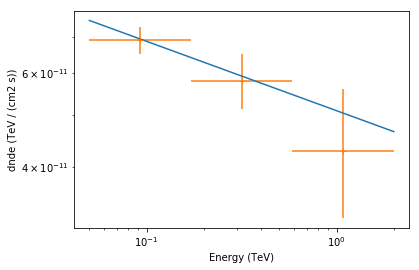

In [40]:
ax = crab_2fhl.spectral_model.plot(
    energy_range=[50, 2000] * u.GeV, energy_power=2,
)
crab_2fhl.flux_points.plot(ax=ax, energy_power=2)

### Exercises

* Plot the spectral model and flux points for PKS 2155-304 for the 3FGL and 2FHL catalogs. Try to plot the error of the model (aka "Butterfly") as well. Note this requires the [uncertainties package](https://pythonhosted.org/uncertainties/) to be installed on your machine.


## What next?

This was a quick introduction to some of the high-level classes in Astropy and Gammapy.

* To learn more about those classes, go to the API docs (links are in the introduction at the top).
* To learn more about other parts of Gammapy (e.g. Fermi-LAT and TeV data analysis), check out the other tutorial notebooks.
* To see what's available in Gammapy, browse the [Gammapy docs](http://docs.gammapy.org/) or use the full-text search.
* If you have any questions, ask on the mailing list.